In [2]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [21]:

path = Config().data_path()/'mnist'
download_data(url='https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz',fname='/home/jupyter/.fastai/data/mnist/mnist.pkl.gz',ext='')
path

PosixPath('/home/jupyter/.fastai/data/mnist')

In [22]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz')]

In [23]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

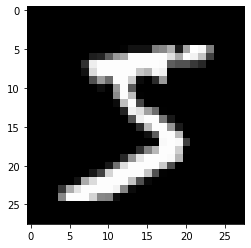

In [24]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [25]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [26]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [27]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [28]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [29]:
model = Mnist_Logistic().cuda()

In [30]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [31]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [32]:
model(x).shape

torch.Size([64, 10])

In [34]:
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[ 7.7276e-03,  6.8697e-03, -3.4893e-02,  ..., -7.8413e-04,
          2.9801e-02, -3.3133e-02],
        [-2.8751e-03,  1.2525e-02,  4.6707e-03,  ..., -7.6350e-05,
         -1.0714e-02,  3.3902e-02],
        [-1.8749e-02, -2.3696e-02, -2.7327e-02,  ...,  3.5420e-02,
         -3.2107e-02,  1.1440e-02],
        ...,
        [-7.8952e-03,  7.1712e-03, -1.2585e-02,  ..., -1.7410e-03,
          2.7532e-02, -1.4042e-02],
        [-4.3763e-03, -2.1554e-02,  1.9574e-02,  ..., -1.6265e-02,
          1.4805e-02, -1.5868e-02],
        [-2.6319e-02,  9.9046e-03,  1.0986e-02,  ..., -1.6670e-03,
         -2.5932e-02,  3.9938e-03]], device='cuda:0', requires_grad=True)


In [37]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [49]:
lr=2e-2

In [50]:
loss_func = nn.CrossEntropyLoss()

In [51]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward() #this is dLoss/dw
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad) # w=w-lr*dLoss/dw
            p.grad.zero_()
    return loss.item()

In [52]:
losses = [update(x,y,lr) for x,y in data.train_dl]

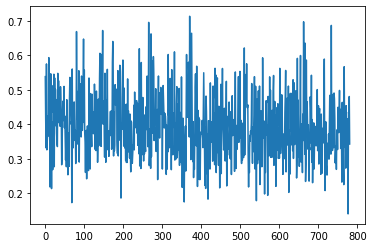

In [53]:
plt.plot(losses);

In [57]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [58]:
model = Mnist_NN().cuda()

In [59]:
losses = [update(x,y,lr) for x,y in data.train_dl]

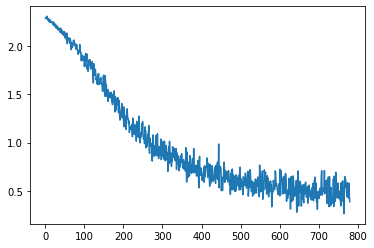

In [60]:
plt.plot(losses);

In [61]:
model = Mnist_NN().cuda()
doc(optim.Adam)

In [68]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [69]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

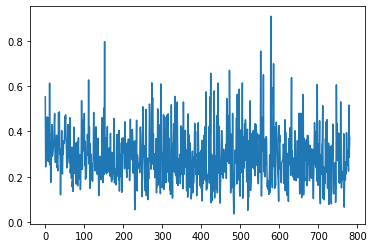

In [70]:
plt.plot(losses);

In [ ]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

AttributeError: 'TensorDataset' object has no attribute 'loss_func'

In [ ]:
%debug

> /home/ubuntu/fastai/fastai/basic_data.py(20)DataLoader___getattr__()
     18 torch.utils.data.DataLoader.__init__ = intercept_args
     19 
---> 20 def DataLoader___getattr__(dl, k:str)->Any: return getattr(dl.dataset, k)
     21 DataLoader.__getattr__ = DataLoader___getattr__
     22 

ipdb> u
> /home/ubuntu/fastai/fastai/basic_data.py(38)__getattr__()
     36 
     37     def __len__(self)->int: return len(self.dl)
---> 38     def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
     39     def __setstate__(self,data:Any): self.__dict__.update(data)
     40 

ipdb> print(k)
loss_func
ipdb> q


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


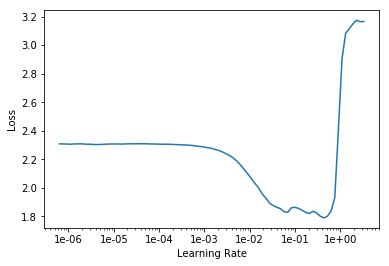

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.129131,0.125927,0.963500


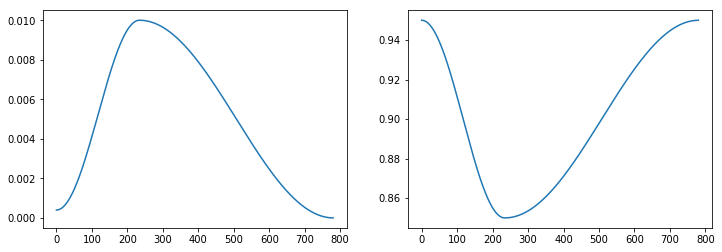

In [ ]:
learn.recorder.plot_lr(show_moms=True)

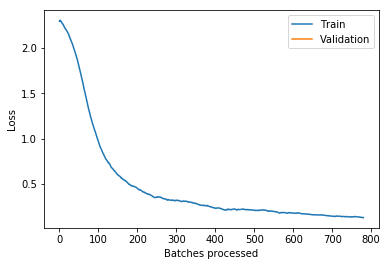

In [ ]:
learn.recorder.plot_losses()

## fin